# import packages

In [662]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import s, l, f, te
from pygam import LinearGAM as linear_gam

# set seaborn look

In [663]:
sns.set(context = "notebook", style = "darkgrid", palette = "colorblind")

# read tabular data from html

In [664]:
biden_favorability_recent, biden_favorability_full = pd.read_html("https://www.realclearpolitics.com/epolls/other/joe_biden_favorableunfavorable-6677.html")

# rename columns

In [665]:
biden_favorability_full.columns = ["poll", "poll_period", "sample_size_population", "favorable_pct", "unfavorable_pct", "net_favorable_pct"]

# remove rcp average row

In [666]:
biden_favorability_full = biden_favorability_full.loc[biden_favorability_full["poll"] != "RCP\xa0Average", ]

# remove "Tie" from net favorability variable

In [667]:
biden_favorability_full["net_favorable_pct"] = biden_favorability_full["net_favorable_pct"].astype(str).str.replace("Tie", "0")

# parse dates

In [668]:
biden_favorability_full[["start_date", "end_date"]] = biden_favorability_full["poll_period"].str.split(" - ").apply(pd.Series)

# parse months and days from date strings

In [669]:
# start month and day
biden_favorability_full[["start_month", "start_day"]] = biden_favorability_full["start_date"].str.split("/").apply(pd.Series)

# end month and day
biden_favorability_full[["end_month", "end_day"]] = biden_favorability_full["end_date"].str.split("/").apply(pd.Series)

# parse sample size and polling population

In [670]:
biden_favorability_full[["sample_size", "polling_population"]] = biden_favorability_full["sample_size_population"].str.split(" ").apply(pd.Series)

# replace "," in sample size
biden_favorability_full["sample_size"] = biden_favorability_full["sample_size"].astype(str).str.replace(",", "")

# cumulative sum of december polling start and end dates

In [671]:
biden_favorability_full["start_december_cumsum"] = (biden_favorability_full["start_month"] == "12").cumsum()
biden_favorability_full["end_december_cumsum"] = (biden_favorability_full["end_month"] == "12").cumsum()

# use cumulative sum to determine year
This is the dumbest solution in the notebook

In [672]:
# recode cumulative sum integer to year string
def cumsum2year(x):
    if x == 0:
        return "2020"
    elif x > 7 and x < 10:
        return "2019"
    else:
        return "2018"

# start adn end year
biden_favorability_full["start_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)
biden_favorability_full["end_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)

# create start and end dates and their midpoint

In [673]:
biden_favorability_full["start_date"] = pd.to_datetime(biden_favorability_full[["start_year", "start_month", "start_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["end_date"] = pd.to_datetime(biden_favorability_full[["end_year", "end_month", "end_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["median_date"] = biden_favorability_full["start_date"] + (biden_favorability_full["end_date"] - biden_favorability_full["start_date"]) / 2

# change data types

In [674]:
biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]] = biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]].astype(int)

# reset index to median date

In [675]:
biden_favorability_full = biden_favorability_full.sort_values("median_date", ascending = True).reset_index(drop = True)
biden_favorability_full.head(n = 10)

,poll,poll_period,sample_size_population,favorable_pct,unfavorable_pct,net_favorable_pct,start_date,end_date,start_month,start_day,end_month,end_day,sample_size,polling_population,start_december_cumsum,end_december_cumsum,start_year,end_year,median_date
0,Harvard-HarrisHarris,8/22 - 8/23,1330 RV,51.0,35.0,16,2018-08-22,2018-08-23,8,22,8,23,1330,RV,10,10,2018,2018,2018-08-22 12:00:00
1,CNNCNN,9/6 - 9/9,923 RV,61.0,28.0,33,2018-09-06,2018-09-09,9,6,9,9,923,RV,10,10,2018,2018,2018-09-07 12:00:00
2,Harvard-HarrisHarris,9/26 - 9/27,1228 RV,55.0,33.0,22,2018-09-26,2018-09-27,9,26,9,27,1228,RV,10,10,2018,2018,2018-09-26 12:00:00
3,Harvard-HarrisHarris,10/26 - 10/28,1835 RV,52.0,35.0,17,2018-10-26,2018-10-28,10,26,10,28,1835,RV,10,10,2018,2018,2018-10-27 00:00:00
4,Harvard-HarrisHarris,11/25 - 11/26,1407 RV,54.0,31.0,23,2018-11-25,2018-11-26,11,25,11,26,1407,RV,10,10,2018,2018,2018-11-25 12:00:00
5,MonmouthMonmouth,12/4 - 12/8,838 RV,43.0,50.0,-7,2018-12-04,2018-12-08,12,4,12,8,838,RV,7,7,2018,2018,2018-12-06 00:00:00
6,QuinnipiacQuinnipiac,12/4 - 12/9,1553 RV,44.0,47.0,-3,2018-12-04,2018-12-09,12,4,12,9,1553,RV,6,6,2018,2018,2018-12-06 12:00:00
7,Economist/YouGovYouGov,12/7 - 12/10,1209 RV,42.0,52.0,-10,2018-12-07,2018-12-10,12,7,12,10,1209,RV,5,5,2018,2018,2018-12-08 12:00:00
8,QuinnipiacQuinnipiac,12/12 - 12/17,1147 RV,53.0,33.0,20,2018-12-12,2018-12-17,12,12,12,17,1147,RV,10,10,2018,2018,2018-12-14 12:00:00
9,Economist/YouGovYouGov,12/14 - 12/17,1164 RV,43.0,51.0,-8,2018-12-14,2018-12-17,12,14,12,17,1164,RV,4,4,2018,2018,2018-12-15 12:00:00


# fit linear GAM

In [676]:
# linear GAM fit
gam_fit = linear_gam(s(0)).fit(biden_favorability_full["median_date"], biden_favorability_full["net_favorable_pct"], weights = biden_favorability_full["sample_size"])

# add predictions to data frame
biden_favorability_full["net_favorable_pct_hat"] = gam_fit.predict(biden_favorability_full["median_date"])

# add confidence intervals
biden_favorability_full = (biden_favorability_full.join(pd.DataFrame(
    gam_fit.confidence_intervals(biden_favorability_full["median_date"], width = 0.95),
    columns = ["lower_pct_hat", "upper_pct_hat"]
)))

# plot GAM predictions compared to 7-day rolling average

Text(0, 0.5, '')

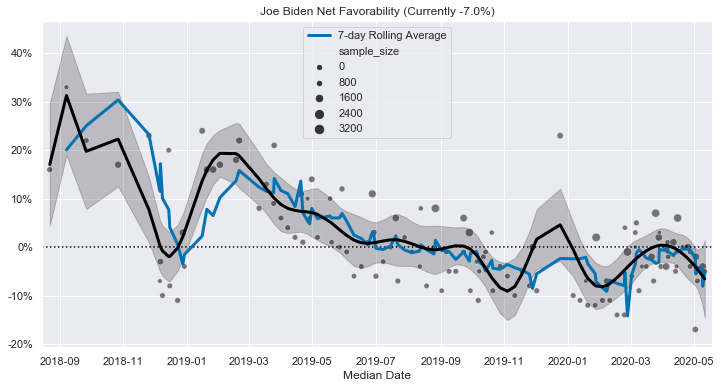

In [677]:
# save 7-day rolling average sample size weights
weights_7dra = biden_favorability_full["sample_size"] / biden_favorability_full["sample_size"].rolling(window = 7, min_periods = 2).mean()

# save figure and axes objects
figure, axes = plt.subplots(figsize = (12, 6))

# scatterplot and lineplot using lowess fit above
axes.axhline(y = 0, linestyle = "dotted", c = "black")
sns.lineplot(x = biden_favorability_full["median_date"], y = biden_favorability_full["net_favorable_pct"].rolling(window = 7, min_periods = 2).mean() * weights_7dra, label = "7-day Rolling Average", linewidth = 3)
sns.lineplot(y = "net_favorable_pct_hat", x = "median_date", data = biden_favorability_full, linewidth = 3, color = "black")
plt.fill_between(biden_favorability_full["median_date"], biden_favorability_full["lower_pct_hat"], biden_favorability_full["upper_pct_hat"], color = "black", alpha = 0.20)
sns.scatterplot(x = "median_date", y = "net_favorable_pct", data = biden_favorability_full, color = "black", size = "sample_size", alpha = 0.50)

# set x-axis limits
axes.set_xlim(biden_favorability_full["median_date"].min() - np.timedelta64(1, "W"), biden_favorability_full["median_date"].max() + np.timedelta64(1, "W"))

# set y-axis label format at percentage %
axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# set titles
axes.set_title("Joe Biden Net Favorability (Currently {}%)".format(biden_favorability_full["net_favorable_pct_hat"][biden_favorability_full.end_date == biden_favorability_full.end_date.max()].round(0).squeeze()))
axes.set_xlabel(xlabel = "Median Date")
axes.set_ylabel(ylabel = None)